# Model training

In [7]:
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

import torch
import torchvision.transforms as transforms
import torchvision.models
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler

import time

import data_reader
import dataset

In [2]:
# Choosing device for tensor processing

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using GPU :", device)
else:
    device = torch.device("cpu")
    print("Using CPU ")

Using GPU : cuda:0


In [3]:
# Training and data variables

MODE = "w"
EXP_NAME = "25ep_earlystp_ft"

DATA_SET_NAME = f"data_set_x20_100%_split"
PATCH_SIZE = 512

BATCH_SIZE = 16
EPOCHS = 25

SIZE_X = PATCH_SIZE
SIZE_Y = PATCH_SIZE

threshold = 0.05 # Loss difference for early stopping

In [4]:
def init_weights(m): # XAVIER initialization for final layer weight initialization
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def init():
    global net, loss_function, scheduler, optimizer, MODEL_NAME

    net = torchvision.models.resnet18(pretrained=True).to(device)
    
    for param in net.parameters():
        param.requires_grad = False # Freezing the convolutional layers

    for param in net.layer4[1].parameters():
        param.requires_grad = True # Unfreezing the last residual block
    
    
    net.fc = nn.Sequential(
                nn.Linear(512, 2),
                #nn.ReLU(inplace=True),
                #nn.Linear(128, 2),
                nn.Softmax(dim = -1)
                ).to(device)

    net.fc.apply(init_weights) # Xavier init

    #print(f"Loading {MODEL_NAME}")
    net = torch.load(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth") # Model loading

    n_params = sum(p.numel() for p in net.fc.parameters())# + sum(p.numel() for p in net.layer4[1].parameters())
    print("Number of free parameters: ", n_params)

    #Hyperparameters:
    learning_rate = 1E-5 # LR
    loss_function = nn.BCELoss()  # Loss # [1,0] es positivo y [0,1] negativo
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)# Optimizer
    lambda1 = lambda epoch: 1 ** epoch # Scheduler
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)


In [5]:
def fwd_pass(X, y, train=False):
# IMPORTANTE, TRAIN = FALSE PARA QUE NO ENTRENE CON EL TEST DATA ESTO ES PARA PODER HACER TEST MIENTRAS ENTRENO Y VALIDO, 
# SE ESPERA QUE LA EXACTITUD EN EL TEST DE VALIDACIÓN SEA MENOR
    if train: 
        net.zero_grad()
        
    # NORMALIZATION
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    normalize = torchvision.transforms.Normalize(mean=mean, std=std)

    for i, x in enumerate(X):
        X[i] = normalize(X[i]/255) # Np array

    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs, y)]
    y_pred = [torch.argmin(i) for i in outputs.cpu()] # 1 means positive diagnosis: (1,0) => 1
    y_true = [torch.argmin(i) for i in y.cpu()]

    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)
    conf_m = confusion_matrix(y_true, y_pred, labels=[0, 1])
    
    if train:
        loss.backward() # Calculate gradients using backprop
        optimizer.step() # Updates W and b using previously calculated gradients

    return acc, loss, conf_m

In [6]:
def train():
  global net, loss_function, scheduler, threshold, optimizer, train_set, val_set, MODEL_NAME, EPOCHS
  
  print(MODEL_NAME)
  patience = 0

  with open(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\log\\model_{MODEL_NAME}.log", MODE) as f:
    for epoch in range(EPOCHS):
      acc, loss = 0, 0,
      val_acc, val_loss = 0, 0,
      conf_m, val_conf_m = np.array([[0,0],[0,0]]), np.array([[0,0],[0,0]])

      print("\nEPOCH: ", epoch+1)

      for batch_X, batch_y in tqdm(iter(train_dataloader)):

        batch_X, batch_y = batch_X.type(torch.FloatTensor).to(device).permute(0, 3, 2, 1), batch_y.type(torch.FloatTensor).to(device) 
        
        net.train() # Making sure that the model is in training mode
        
        acc_aux, loss_aux, conf_m_aux = fwd_pass(batch_X, batch_y, train=True)
        
        acc += acc_aux*(len(batch_X)/len(train_set)) # Calculating the average loss and acc through batches sum ACCi*Wi/N (Wi = weight of the batch)
        loss += loss_aux*(len(batch_X)/len(train_set))
        conf_m += conf_m_aux

        """
        i += 1
    
        if i%100 == 0:
          print("Memory allocated in GPU: ", torch.cuda.memory_allocated("cuda:0")/1024/1024/1024)
        """
        
      for batch_X, batch_y in tqdm(iter(val_dataloader)):

        batch_X, batch_y = batch_X.type(torch.FloatTensor).to(device).permute(0, 3, 2, 1), batch_y.type(torch.FloatTensor).to(device)

        net.eval() # Making sure that the model is not training and deactivate droptout
        
        with torch.no_grad(): # Disable all computations, works together with net.eval()
          acc_aux, loss_aux, conf_m_aux = fwd_pass(batch_X, batch_y, train=False)

        val_acc += acc_aux*(len(batch_X)/len(val_set)) # Calculating the average loss and acc trough batches
        val_loss += loss_aux*(len(batch_X)/len(val_set))
        val_conf_m += conf_m_aux


      acc = (conf_m[0][0]+conf_m[1][1])/(conf_m[1][0]+conf_m[0][1]+conf_m[1][1]+conf_m[0][0]) # Better way to obtain acc tan using per batch acc
      val_acc = (val_conf_m[0][0]+val_conf_m[1][1])/(val_conf_m[1][0]+val_conf_m[0][1]+val_conf_m[1][1]+val_conf_m[0][0])

      prc = conf_m[1][1]/(conf_m[1][1]+conf_m[0][1])
      val_prc = val_conf_m[1][1]/(val_conf_m[1][1]+val_conf_m[0][1])
      rec = conf_m[1][1]/(conf_m[1][1]+conf_m[1][0])
      val_rec = val_conf_m[1][1]/(val_conf_m[1][1]+val_conf_m[1][0])
      f1 = 2*prc*rec/(prc+rec)
      val_f1 = 2*val_prc*val_rec/(val_prc+val_rec)
      
      print("Val loss: ", val_loss.item()," Train loss: ", loss.item(), "\n")
      print("Val acc: ", val_acc," Train acc: ", acc, "\n")
      print("Val PRC:", val_prc, "Train PRC: ", prc) # TP/TP+FP
      print("Val REC: ", val_rec,"Train REC: ", rec) # TP/TP+FN
      print("Val f1: ", val_f1," Train f1: ", f1, "\n")
      print("Val CONF: \n", val_conf_m,"\nTrain CONF: \n", conf_m, "\n")

      conf_m = f"{conf_m[0][0]}+{conf_m[0][1]}+{conf_m[1][0]}+{conf_m[1][1]}"
      val_conf_m = f"{val_conf_m[0][0]}+{val_conf_m[0][1]}+{val_conf_m[1][0]}+{val_conf_m[1][1]}"
    
      f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),3)},{round(float(loss),4)},{conf_m},{round(float(prc),4)},{round(float(rec),4)},")
      f.write(f"{round(float(val_acc),3)},{round(float(val_loss),4)},{val_conf_m}, {round(float(val_prc),4)}, {round(float(val_rec),4)}\n")
      f.write("\n\n")

      # Early stopping, if the difference between loss and validation loss 
      # is bigger than the threshold for 3 epochs in a row training is stopped
      if loss.item()-val_loss.item()> threshold:
        patience +=1
      else:
        patience = 0

      print("Learning Rate: ", optimizer.param_groups[0]["lr"])
      scheduler.step() # Changing the learning rate

      if patience >= 4:
        print("Stopping early: ")
        break

    torch.save(net, f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth")

def test():
  global test_set, test_dataloader, MODEL_NAME, MODE

  with open(r"C:\Users\Alejandro\Desktop\heterogeneous-data\results\WSI\test.csv", MODE) as f:
    acc, loss = 0, 0
    conf_m = np.array([[0,0],[0,0]])
    for batch_X, batch_y in tqdm(iter(test_dataloader)):
      batch_X, batch_y = batch_X.type(torch.FloatTensor).to(device).permute(0, 3, 2, 1), batch_y.type(torch.FloatTensor).to(device)

      net.eval() # Making sure that the model is not training and deactivate droptout

      with torch.no_grad(): # Disable all computations, works together with net.eval()
          acc_aux, loss_aux, conf_m_aux = fwd_pass(batch_X, batch_y, train=False)

      acc += acc_aux*(len(batch_X)/len(test_set)) # Calculating the average loss and acc trough batches
      loss += loss_aux*(len(batch_X)/len(test_set))
      conf_m += conf_m_aux

    prc = conf_m[0][0]/(conf_m[0][0]+conf_m[0][1])
    rec = conf_m[0][0]/(conf_m[0][0]+conf_m[0][1])
    f1 = 2*prc*rec/(prc+rec)

    print("Test loss: ", loss.item(), "\n")
    print("Test acc: ", acc, "\n")
    print("Test PRC: ", prc, "\n") # TP/TP+FP
    print("Test REC: ", rec, "\n") # TP/TP+FN
    print("f1: ", f1, "\n")
    print("\nCONF: \n", conf_m, "\n")

In [7]:
# Choosing only the images from the according splits (10CV)

SPLITS = 1 # Number of iterations > n_splits
n_splits = 10 # Number of splits to use

for SPLIT in range(SPLITS):
    MODEL_NAME = EXP_NAME + f"{SPLIT}"

    TRAIN_SPLITS = list(range(n_splits))
    # We take out the SPLIT and SPLIT+1 sets for val and testing
    if SPLIT == n_splits: # For the final split for validation we take the firs one for test
        TRAIN_SPLITS.remove(0) 
    else:
        TRAIN_SPLITS.remove(SPLIT+1)
    TRAIN_SPLITS.remove(SPLIT)

    train_set = dataset.PatchDataset([], [], [])
    val_set = dataset.PatchDataset([], [], [])
    test_set = dataset.PatchDataset([], [], [])

    # Loading training splits:
    for i in TRAIN_SPLITS:
        print(f"Loading training split: {i}")
        SPLIT_NAME = DATA_SET_NAME + f"{i}"
        
        X_, y_, _ , _ = data_reader.read_lmdb(f"C:/Users/Alejandro/Desktop/heterogeneous-data/data/WSI/patches/{SPLIT_NAME}")

        train_set.inputs.extend(X_)
        train_set.labels.extend(y_)

    # Random oversampler

    y =  [i[0] for i in train_set.labels]
    positive = sum(y)
    class_sample_count = np.array([len(y)-positive ,positive])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in y])
    samples_weight = torch.from_numpy(samples_weight) # Probability for a sample to be sampled
    #samples_weight = torch.tensor([1/len(samples_weight)]*len(samples_weight))
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))#, replacement=False)
    # Will take len(samples_weight) number of samples, this can be changed
    
    # Creating DataLoader
    train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, sampler=sampler)
    
    print(f"Patches for training: {len(train_set)}\n")
    
    # Loading validation splits:
    SPLIT_NAME = DATA_SET_NAME + f"{SPLIT}"

    print(f"Loading validation split: {SPLIT}")

    X_, y_, _ , _ = data_reader.read_lmdb(f"C:/Users/Alejandro/Desktop/heterogeneous-data/data/WSI/patches/{SPLIT_NAME}")

    val_set.inputs.extend(X_)
    val_set.labels.extend(y_)

    val_dataloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

    print(f"Patches for validation: {len(val_set)}\n")

    # Loading validation splits:
    if SPLIT == n_splits:
        SPLIT_NAME = DATA_SET_NAME + f"{0}"
        print(f"Loading test split: {0}")
    else:
        SPLIT_NAME = DATA_SET_NAME + f"{SPLIT+1}"
        print(f"Loading test split: {SPLIT+1}")

    X_, y_, _ , _ = data_reader.read_lmdb(f"C:/Users/Alejandro/Desktop/heterogeneous-data/data/patches/{SPLIT_NAME}")

    test_set.inputs.extend(X_)
    test_set.labels.extend(y_)

    test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

    print(f"Patches for test: {len(test_set)}\n")

    init()

    train()

    del train_set, val_set, test_set


Loading training split: 2
Read lmdb
Loading training split: 3
Read lmdb
Loading training split: 4
Read lmdb
Loading training split: 5
Read lmdb
Loading training split: 6
Read lmdb
Loading training split: 7
Read lmdb
Loading training split: 8
Read lmdb
Loading training split: 9
Read lmdb
Patches for training: 118075

Loading validation split: 0
Read lmdb
Patches for validation: 16928

Loading test split: 1
Read lmdb


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Alejandro/Desktop/heterogeneous-data/data/patches/data_set_x20_100%_split1'

In [8]:
def learning_curve(NAME):
  fig, axs = plt.subplots(2, figsize = (7,6))

  acc_df = pd.read_csv(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\log\\model_{NAME}.log")
  acc_df.columns = ["MODEL_NAME", "TIME", "ACC", "LOSS", "CONF_M", "PRC", "REC",
                     "VAL_ACC", "VAL_LOSS", "VAL_CONF_M", "VAL_PRC", "VAL_REC"]

  fig, axs = plt.subplots(2, figsize=(5,7))

  axs[0].legend("MODEL_NAME", loc=2)

  acc_df.plot(y="ACC", ax=axs[0])
  acc_df.plot(y="VAL_ACC", ax=axs[0])

  acc_df.plot(y="LOSS", ax=axs[1])
  acc_df.plot(y="VAL_LOSS",ax=axs[1])

  fig.show()
  fig.savefig(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\lc\\l_curve_{NAME}.pdf")

25ep_earlystp_ft0


EmptyDataError: No columns to parse from file

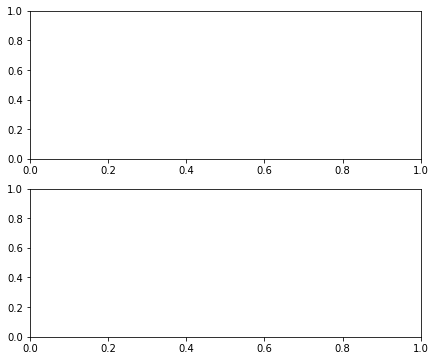

In [9]:
for SPLIT in range(1):
    NAME = EXP_NAME + f"{SPLIT}"
    print(NAME)
    learning_curve(NAME)